# Stat. Lect. 14 - Bayesian Network

## The transportation means survey
- let’s consider an hypothetical survey whose aim is to investigate the usage patterns of different means of transport, with a focus on private cars and public trains or buses
- each regular commuting individual fills a questionnaire on the following six discrete variables:
    - Age **(A)**: below 30 (young), between 30 and 60 (adult) greater than 60 (senior)
    - Sex **(S)**: male (M) or female (F)
    - Education **(E)**: highest individual degree between high school (high) and university or higher (uni)
    - Occupation **(O)**: weather the individual is an employee (empl) or a self-employedworker (self)
    - Residence **(R)**: the size of the city the individual lives in, a (small) or (big) town
    - Travel **(T)**: the means of transport flavored by the individual, car, train or bus
- the variables can be grouped into demographic indicators (Age and Sex), socioeconomic indicators (Education, Occupation and Residence) and the target of the survey (Travel)

In [14]:
# Installed just by typing install.packages('bnlearn')
library(bnlearn)

# This was a bit more complicated to install:
# install.packages("BiocManager")
# BiocManager::install("Rgraphviz")
library(Rgraphviz)

In [5]:
# Setting the nodes
tus_dag <- empty.graph(nodes = c("A", "S", "E", "O", "R", "T"))

# Setting the arc (the edges)
tus_dag <- set.arc(tus_dag, from = "A", to = "E")
tus_dag <- set.arc(tus_dag, from = "S", to = "E")
tus_dag <- set.arc(tus_dag, from = "E", to = "O")
tus_dag <- set.arc(tus_dag, from = "E", to = "R")
tus_dag <- set.arc(tus_dag, from = "O", to = "T")
tus_dag <- set.arc(tus_dag, from = "R", to = "T")

In [6]:
tus_dag


  Random/Generated Bayesian network

  model:
   [A][S][E|A:S][O|E][R|E][T|O:R] 
  nodes:                                 6 
  arcs:                                  6 
    undirected arcs:                     0 
    directed arcs:                       6 
  average markov blanket size:           2.67 
  average neighbourhood size:            2.00 
  average branching factor:              1.00 

  generation algorithm:                  Empty 


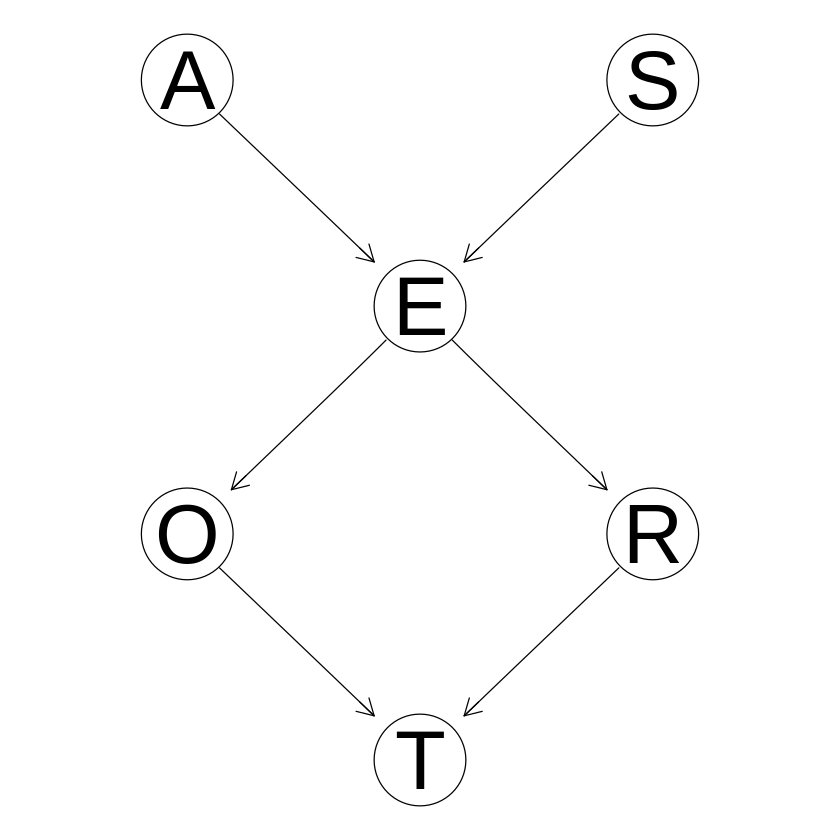

In [17]:
graphviz.plot(tus_dag)

In [7]:
nodes(tus_dag)

[1] "A" "S" "E" "O" "R" "T"

In [8]:
# The neighbourhood of E
nbr(tus_dag, "E")

[1] "A" "S" "O" "R"

In [9]:
# The parents of E
parents(tus_dag, "E")

[1] "A" "S"

In [10]:
# The children of E
children(tus_dag, "E")

[1] "O" "R"

In [18]:
# look for roots (nodes with no parents)
root.nodes(tus_dag)

[1] "A" "S"

In [19]:
# look for leaves (nodes with no children)
leaf.nodes(tus_dag)

[1] "T"

In [20]:
# Another way to create the network is using the model formula interface provided by modelstring
dag <- empty.graph(nodes = c("A", "S", "E", "O", "R", "T") )
dag2 <- model2network("[A][S][E|A:S][O|E][R|E][T|O:R]")
all.equal(tus_dag, dag2) # Check if the network is the same

[1] TRUE

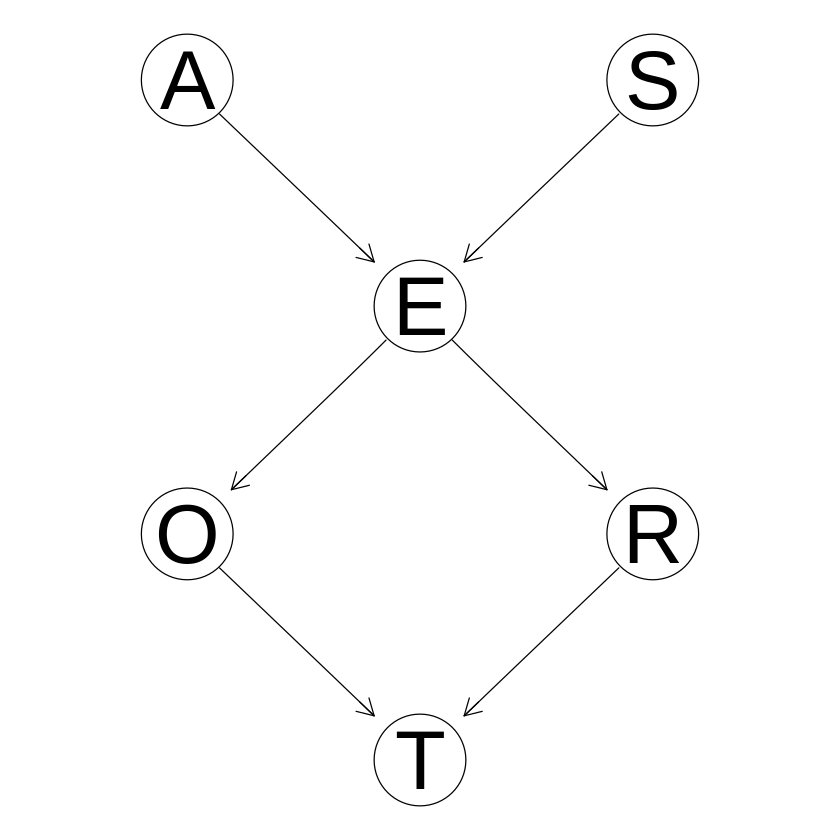

In [21]:
graphviz.plot(dag2)

In [22]:
A_lvl <- c("young", "adult", "old")
S_lvl <- c("M", "F")
E_lvl <- c("high", "uni")
O_lvl <- c("emp", "self")
R_lvl <- c("small", "big")
T_lvl <- c("car", "train", "other")

In [26]:
# Specify the joint probabilities

A_prob <- array(c(0.30, 0.50, 0.20), dim = 3, 
                dimnames = list(A = A_lvl))

S_prob <- array(c(0.60, 0.40), dim = 2, 
                dimnames = list(S = S_lvl))

O_prob <- array(c(0.96, 0.04, 0.92, 0.08), dim = c(2, 2), 
                dimnames = list(O = O_lvl , E = E_lvl))

R_prob <- matrix (c(0.25, 0.75, 0.20, 0.80), ncol = 2, 
                dimnames = list(R = R_lvl , E = E_lvl))

E_prob <- array(c(0.75, 0.25, 0.72, 0.28, 0.88, 0.12, 0.64, 0.36, 0.70, 0.30, 0.90, 0.10),
               dim = c(2, 3, 2), dimnames = list(E = E_lvl, A = A_lvl, S = S_lvl))

T_prob <- array(c(0.48, 0.42, 0.10, 0.56, 0.36, 0.08, 0.58, 0.24, 0.18, 0.70, 0.21, 0.09),
               dim = c(3, 2, 2), dimnames = list(T = T_lvl, O = O_lvl, R = R_lvl))

In [54]:
# Associate the probabilities to the BN model
cpt <- list(A = A_prob, S = S_prob, E = E_prob, O = O_prob, R = R_prob, T = T_prob)
bn <- custom.fit(tus_dag, cpt)

In [97]:
survey <- read.table("survey.txt", header = TRUE, stringsAsFactors = TRUE)
head(survey, n=3)

A,R,E,O,S,T
adult,big,high,emp,F,car
adult,small,uni,emp,M,car
adult,big,uni,emp,F,train


We can factorize the global distribution:

$$P(A,S,E,O,R,T)=P(A)\cdot P(S) \cdot P(E|A,S)\cdot P(O|E) \cdot P(R|E) \cdot P(T|O,R)$$

The conditional probabilities can be estimated looking at the corresponding empirical frequencies in the data set

$$P(O=emp|E=high)=\frac{P(O=emp,E=high)}{P(E=high)}$$

In [101]:
travel_dag <- model2network("[A][S][E|A:S][O|E][R|E][T|O:R]")

bn.mle <- bn.fit(travel_dag, data = survey, method = "mle")

# alternative method
bn.bayes <- bn.fit(travel_dag, data = survey, method = "bayes", iss = 10)

Loading required namespace: lattice



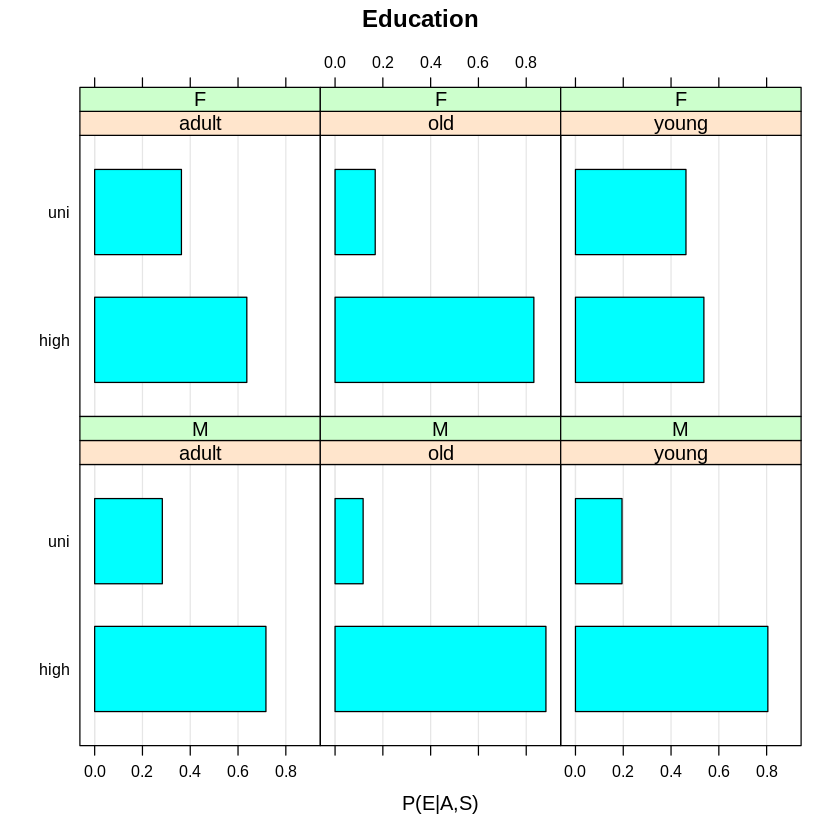

In [102]:
# We can plot the probabilities associated to each link of the network
bn.fit.barchart(bn.bayes$E, main = "Education", xlab = "P(E|A,S)", ylab = "")

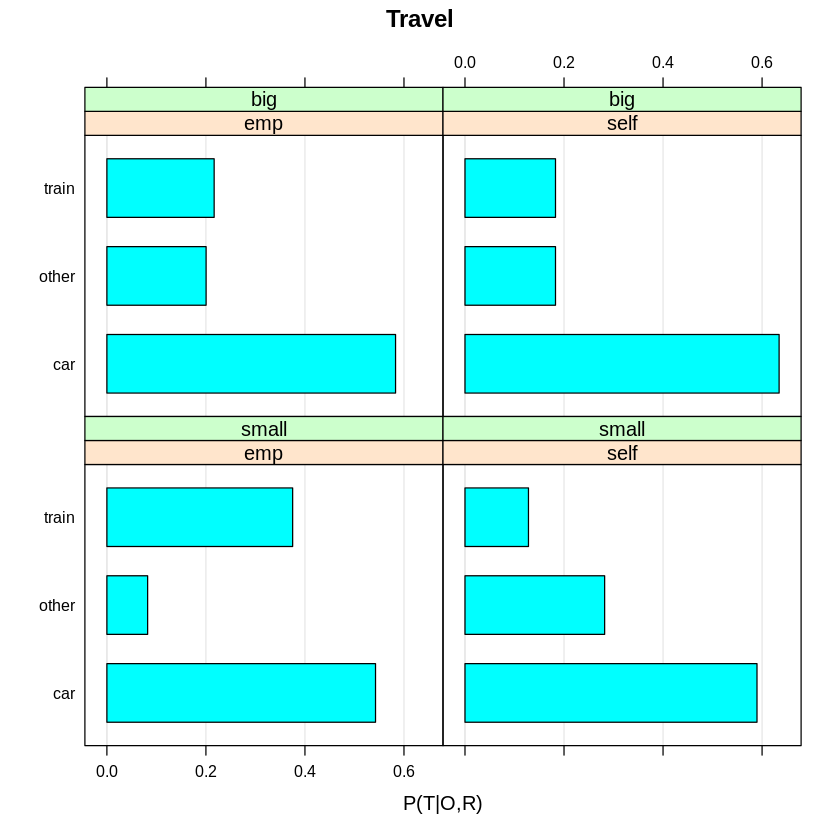

In [103]:
bn.fit.barchart(bn.bayes$T, main = "Travel", xlab = "P(T|O,R)", ylab = "")

In [105]:
# Investigating a DAG structure from data

In [106]:
ci.test("T", "E", c("O","R"), test = "mi", data = survey)


	Mutual Information (disc.)

data:  T ~ E | O + R
mi = 9.8836, df = 8, p-value = 0.2733
alternative hypothesis: true value is greater than 0


In [107]:
ci.test("T", "E", c("O","R"), test = "x2", data = survey)


	Pearson's X^2

data:  T ~ E | O + R
x2 = 8.2375, df = 8, p-value = 0.4106
alternative hypothesis: true value is greater than 0


In [108]:
# Evaluate scores

In [109]:
# Bayesian Information Criterion
score(travel_dag, data = survey, type = "bic")

[1] -2012.687

In [110]:
# Bayesian Dirichlet equivalent uniform
score(travel_dag, data = survey, type = "bde")

[1] -2015.647